In [6]:
import sys
from pathlib import Path

qml_path = (Path.cwd() / "../../QML").resolve()
sys.path.insert(0, str(qml_path))

from Qsun.Qkernels import *
from Qsun.Qgates import *
from Qsun.Qmeas import *
from Qsun.Qcircuit import *
from Qsun.Qwave import *

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

np.random.seed(1234)

In [7]:
X, y = fetch_openml("Fashion-MNIST", version=1, as_frame=False, return_X_y=True)
y = np.asarray(y)                 
y = y.astype(str).astype(int) 

x_train, x_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]
x_train = x_train.reshape(-1, 28, 28)
x_test  = x_test.reshape(-1, 28, 28)
x_train, x_test = x_train/255.0, x_test/255.0

print("Original shapes:", x_train.shape, y_train.shape, x_test.shape, y_test.shape)
print("Original labels:", np.unique(y_train))


Original shapes: (60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
Original labels: [0 1 2 3 4 5 6 7 8 9]


# Data Preprocessing

In [8]:
def dim_red(x_train, x_test, n_components=20):
    if len(x_train.shape) > 2:
        x_train = x_train.reshape(x_train.shape[0], -1)
        x_test = x_test.reshape(x_test.shape[0], -1)
    
    pca = PCA(n_components=n_components)
    x_train_pca = pca.fit_transform(x_train)
    x_test_pca = pca.transform(x_test)

    print(f"Reduced dim: {x_train_pca.shape[1]}, Variance: {np.sum(pca.explained_variance_ratio_):.2%}")
    return x_train_pca, x_test_pca

dataset_dim = 4
x_train, x_test = dim_red(x_train, x_test, n_components=dataset_dim)

N_train = 600
N_test = 200   
x_train, x_test = x_train[:N_train], x_test[:N_test]
y_train, y_test = y_train[:N_train], y_test[:N_test]
print(f"Training: {len(x_train)}, Testing: {len(x_test)}")

Reduced dim: 4, Variance: 57.77%
Training: 600, Testing: 200


# Quantum Feature Map

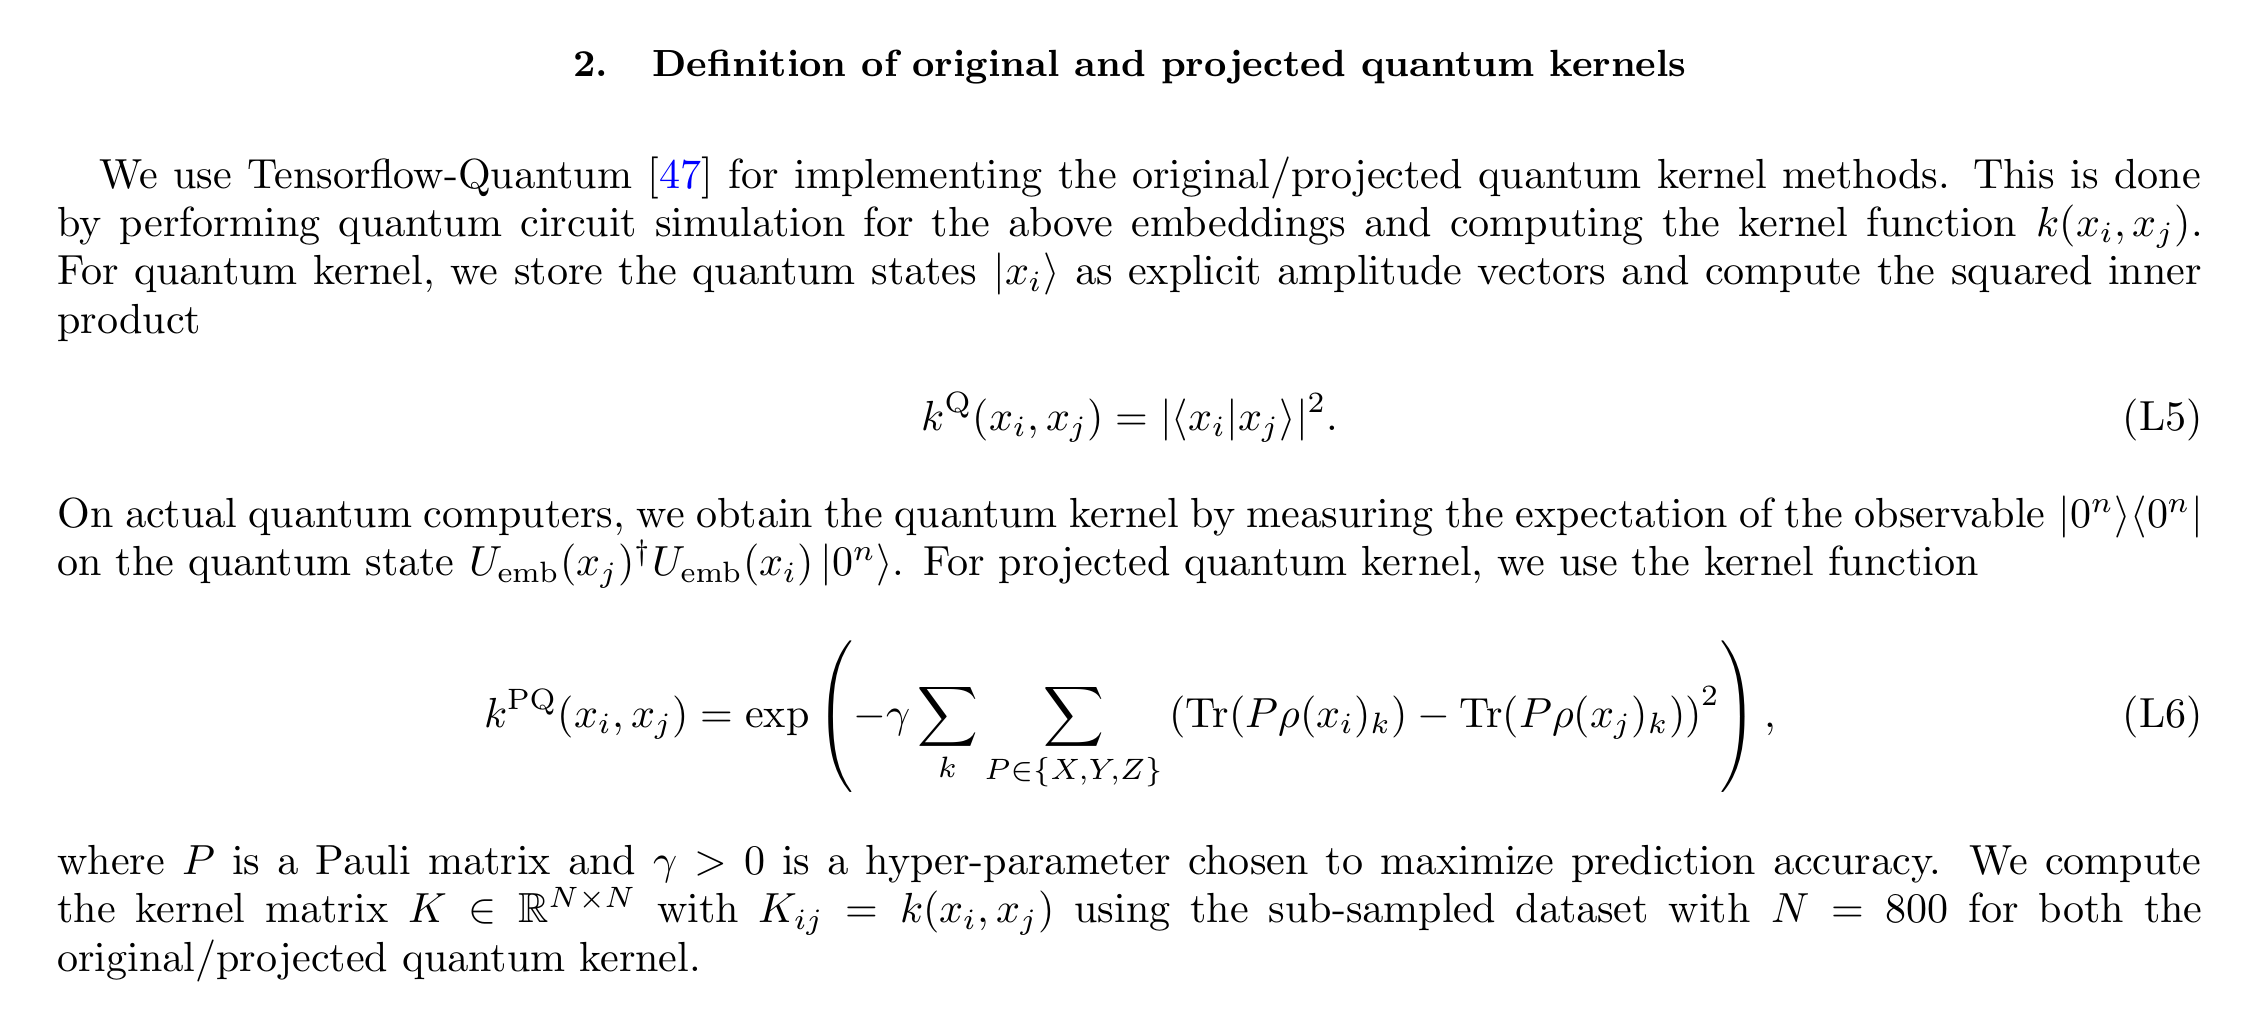

The Projected Quantum Kernel is implemented in the `Qkernels.py`. 

From the Appendix L: Details of numerical studies - Article: Power of data in quantum machine learning, we apply the Pauli Measurements (X-Y-Z) on the quantum circuit, where I have defined as `pauli_expectation` function in `Qmeas.py`. 

Then, from n_features (classical space), it becomes to 3 * n_features (in the quantum space)

In [9]:
n_qubits = dataset_dim 
n_layers = 2  
n_params = n_qubits + n_layers * (n_qubits - 1)

def pqk_circuit_fn(n_qubits, n_layers):
    def circuit_fn(features, params):
        wavefunction = Qubit(n_qubits)

        for q in range(n_qubits):
            RY(wavefunction, q, params[q])

        param_offset = n_qubits
        
        for layer in range(n_layers):
            for q in range(n_qubits):
                feat_idx = q % len(features)
                RX(wavefunction, q, features[feat_idx])
            
            for q in range(n_qubits - 1):
                param_idx = param_offset + layer * (n_qubits - 1) + q
                CRZ(wavefunction, q, q+1, params[param_idx])
        
        measurements = []
        for qubit_idx in range(n_qubits):
            for pauli in ['X', 'Y', 'Z']:
                exp_val = pauli_expectation(wavefunction, qubit_idx, pauli)
                measurements.append(exp_val)
        return measurements
    
    return circuit_fn

pqk_circuit = pqk_circuit_fn(n_qubits, n_layers)

params = np.random.uniform(-2, 2, size=n_params)

pqk_kernel = ProjectedQuantumKernel(
    circuit_fn=pqk_circuit,
    n_qubits=n_qubits,
    n_layers=n_layers,
    params=params,
    gamma=1.0,
    random_state=42
)

In [10]:
x_train_pqk = pqk_kernel.compute_quantum_features(x_train)
x_test_pqk = pqk_kernel.compute_quantum_features(x_test)
K_pqk_train = pqk_kernel.kernel_matrix(x_train, x_train)
K_pqk_test = pqk_kernel.kernel_matrix(x_test, x_train)

print(f"PQK train features shape: {x_train_pqk.shape}")
print(f"PQK test features shape: {x_test_pqk.shape}")

PQK train features shape: (600, 12)
PQK test features shape: (200, 12)


In [11]:
def classical_kernel(X1, X2, gamma=0.005):
    n1, n2 = len(X1), len(X2)
    K = np.zeros((n1, n2))
    
    for i in range(n1):
        for j in range(n2):
            diff = X1[i] - X2[j]
            K[i, j] = np.exp(-gamma * np.sum(diff ** 2))
    
    return K

K_classical_train = classical_kernel(x_train, x_train, gamma=1.0)
K_classical_test = classical_kernel(x_test, x_train, gamma=1.0)


# Generate quantum labels from geometric difference



### Geometric Difference and Label Generation (Concise Derivation)

**Definition.** The geometric difference between the quantum and classical kernels is
$$
g^2=\left\lVert
\sqrt{K^Q}\,\sqrt{K^C}\,(K^C+\lambda I)^{-2}\,\sqrt{K^C}\,\sqrt{K^Q}
\right\rVert_{\infty},
$$
where $\lVert\cdot\rVert_\infty$ is the spectral norm (largest eigenvalue).

**SVDs.** Write
$$
K^Q = U\,\Sigma_Q^2\,U^\dagger,\qquad
K^C = V\,\Sigma_C^2\,V^\dagger.
$$
Then
$$
\begin{aligned}
M
&=\sqrt{K^Q}\,\sqrt{K^C}\,(K^C+\lambda I)^{-2}\,\sqrt{K^C}\,\sqrt{K^Q}\\
&=U\,\Sigma_Q\,U^\dagger\,V\,\Sigma_C\,(\Sigma_C^2+\lambda I)^{-2}\,\Sigma_C\,V^\dagger\,U\,\Sigma_Q\,U^\dagger\\
&=U\,A\,U^\dagger,
\end{aligned}
$$
with
$$
A=\Sigma_Q\,V\,\Sigma_C\,(\Sigma_C^2+\lambda I)^{-2}\,\Sigma_C\,V^\dagger\,\Sigma_Q.
$$

**Consequence.** Since $M$ and $A$ are similar, they share eigenvalues; hence
$$
g^2=\lambda_{\max}(M)=\lambda_{\max}(A).
$$

**Labels.** Let $w$ be the eigenvector of $A$ associated with $\lambda_{\max}(A)$.  
The corresponding eigenvector in the original space is $v=U\,w$, and the quantum labels are
$$
y=\sqrt{K^Q}\,v=U\,\Sigma_Q\,w.
$$

**Code correspondence.**
- `scaling` $\equiv A$  
- `V_pqk` $\equiv U$, `S_pqk` $\equiv \Sigma_Q$  
- `V_classical` $\equiv V$, `S_classical` $\equiv \Sigma_C$  
- Largest eigenvector of `scaling` = $w$; labels via `V_pqk @ diag(S_pqk) @ w = U\,\Sigma_Q\,w`.


In [12]:
def get_spectrum(K):
    eigenvalues, eigenvectors = np.linalg.eigh(K)
    eigenvalues = np.abs(eigenvalues)
    return eigenvalues, eigenvectors

def new_label_wnoise(S_pqk, V_pqk, S_classical, V_classical, lambda_v=1.1):
    
    S_classical_scaled = np.diag(S_classical**2 / (S_classical**2 + lambda_v) ** 2)
    scaling = np.diag(S_pqk) @ V_pqk.T @ V_classical @ S_classical_scaled @ V_classical.T @ V_pqk @ np.diag(S_pqk)
    
    eig_vals, eig_vecs = np.linalg.eig(scaling)
    largest_eigvec = eig_vecs[:, np.argmax(np.abs(eig_vals))]

    new_labels = np.real(V_pqk @ np.diag(S_pqk) @ largest_eigvec)
    final_y = new_labels > np.median(new_labels)
    noise_mask = np.random.uniform(size=final_y.shape) > 0.95
    noisy_y = final_y ^ noise_mask
    
    return noisy_y.astype(int)


In [13]:
x_combined_classical = np.vstack([x_train, x_test])

K_pqk_full = pqk_kernel.kernel_matrix(x_combined_classical,x_combined_classical)
K_classical_full = classical_kernel(x_combined_classical,x_combined_classical, gamma=1.0)

S_pqk, V_pqk = get_spectrum(K_pqk_full)
S_classical, V_classical = get_spectrum(K_classical_full)

print(f"\nPQK eigenvalues range: [{S_pqk.min():.4f}, {S_pqk.max():.4f}]")
print(f"Classical eigenvalues range: [{S_classical.min():.4f}, {S_classical.max():.4f}]")


PQK eigenvalues range: [0.0003, 76.0946]
Classical eigenvalues range: [0.0005, 16.6676]


In [14]:
y_relabel = new_label_wnoise(S_pqk, V_pqk, S_classical, V_classical, lambda_v=1.1)

y_train_new = y_relabel[:N_train]
y_test_new = y_relabel[N_train:N_train+N_test] 

# Model Evaluation
## 1. Support Vector Classifier

In [ ]:
# 1) Classical-SVC với classical features + classical labels
cls_svc_cc = SVC(
    kernel='rbf',
    gamma=1.0,
    C=10,
    random_state=42
)
cls_svc_cc.fit(x_train, y_train)
y_pred_cc = cls_svc_cc.predict(x_test)
acc_cc = accuracy_score(y_test, y_pred_cc)

# 2) Classical-SVC với classical features + quantum labels 
cls_svc_cq = SVC(
    kernel='rbf',
    gamma=1.0,
    C=10,
    random_state=42
)
cls_svc_cq.fit(x_train, y_train_new)
y_pred_cq = cls_svc_cq.predict(x_test)
acc_cq = accuracy_score(y_test_new, y_pred_cq)

# 3) PQK-SVC với quantum features + classical labels
pqk_svc_qc = SVC(
    kernel='precomputed',
    C=10,
    random_state=42
)
pqk_svc_qc.fit(K_pqk_train, y_train)
y_pred_qc = pqk_svc_qc.predict(K_pqk_test)
acc_qc = accuracy_score(y_test, y_pred_qc)

# 4) PQK-SVC với quantum features + quantum labels
pqk_svc_qq = SVC(
    kernel='precomputed',
    C=10,
    random_state=42
)
pqk_svc_qq.fit(K_pqk_train, y_train_new)
y_pred_qq = pqk_svc_qq.predict(K_pqk_test)
acc_qq = accuracy_score(y_test_new, y_pred_qq)

print("ACCURACY COMPARISON (Classical vs Projected Quantum)")
print(f"[1] Classical feat + Classical label  -> Classical SVC : {acc_cc*100:6.2f}%")
print(f"[2] Classical feat + Quantum  label  -> Classical SVC : {acc_cq*100:6.2f}%")
print(f"[3] Quantum features + Classical label  -> PQK-SVC      : {acc_qc*100:6.2f}%")
print(f"[4] Quantum features + Quantum  label   -> PQK-SVC      : {acc_qq*100:6.2f}%")


ACCURACY COMPARISON (Classical vs Projected Quantum)
[1] Classical feat + Classical label  -> Classical SVC :  63.50%
[2] Classical feat + Quantum  label  -> Classical SVC :  67.00%
[3] Quantum features + Classical label  -> PQK-SVC      :  36.50%
[4] Quantum features + Quantum  label   -> PQK-SVC      :  82.50%


## 2. Multilayer Perceptron Classifier

In [16]:
# 1) Classical-MLPC với classical features + classical labels
cls_mlpc_cc = MLPClassifier(
    hidden_layer_sizes=(32, 16),
    activation='logistic',
    max_iter=1000,
    learning_rate_init=0.03,
    random_state=42,
    verbose=False
)
cls_mlpc_cc.fit(x_train, y_train)
y_pred_cc = cls_mlpc_cc.predict(x_test)
acc_cc = accuracy_score(y_test, y_pred_cc)

# 2) Classical-SVC với classical features + quantum labels
cls_mlpc_cq = MLPClassifier(
    hidden_layer_sizes=(32, 16),
    activation='logistic',
    max_iter=1000,
    learning_rate_init=0.03,
    random_state=42,
    verbose=False
)
cls_mlpc_cq.fit(x_train, y_train_new)
y_pred_cq = cls_mlpc_cq.predict(x_test)
acc_cq = accuracy_score(y_test_new, y_pred_cq)

# 3) PQK-SVC với quantum features + classical labels
pqk_mlpc_qc = MLPClassifier(
    hidden_layer_sizes=(32, 16),
    activation='logistic',
    max_iter=1000,
    learning_rate_init=0.03,
    random_state=42,
    verbose=False
)
pqk_mlpc_qc.fit(K_pqk_train, y_train)
y_pred_qc = pqk_mlpc_qc.predict(K_pqk_test)
acc_qc = accuracy_score(y_test, y_pred_qc)

# 4) PQK-SVC với quantum features + quantum labels
pqk_mlpc_qq = MLPClassifier(
    hidden_layer_sizes=(32, 16),
    activation='logistic',
    max_iter=1000,
    learning_rate_init=0.03,
    random_state=42,
    verbose=False
)
pqk_mlpc_qq.fit(K_pqk_train, y_train_new)
y_pred_qq = pqk_svc_qq.predict(K_pqk_test)
acc_qq = accuracy_score(y_test_new, y_pred_qq)

print("ACCURACY COMPARISON (Classical vs Projected Quantum)")
print(f"[1] Classical feat + Classical label  -> Classical SVC : {acc_cc*100:6.2f}%")
print(f"[2] Classical feat + Quantum  label  -> Classical SVC : {acc_cq*100:6.2f}%")
print(f"[3] Quantum features + Classical label  -> PQK-SVC      : {acc_qc*100:6.2f}%")
print(f"[4] Quantum features + Quantum  label   -> PQK-SVC      : {acc_qq*100:6.2f}%")


ACCURACY COMPARISON (Classical vs Projected Quantum)
[1] Classical feat + Classical label  -> Classical SVC :  62.50%
[2] Classical feat + Quantum  label  -> Classical SVC :  69.50%
[3] Quantum features + Classical label  -> PQK-SVC      :  31.50%
[4] Quantum features + Quantum  label   -> PQK-SVC      :  82.50%


# Geometric Difference

We define the geometric difference $g$ between the quantum and classical kernels as

$$
g^2 = \left\lVert 
\sqrt{K^Q}\sqrt{K^C}(K^C + \lambda I)^{-2}\sqrt{K^C}\sqrt{K^Q}
\right\rVert_{\infty},
$$

where $\lVert \cdot \rVert_{\infty}$ denotes the spectral norm (i.e., the largest eigenvalue).

To compute $g$, we follow the same procedure as described above.  
By applying the singular value decompositions

$$
K^Q = U\Sigma_Q^2 U^\dagger, \qquad
K^C = V\Sigma_C^2 V^\dagger,
$$

we can express the operator inside the norm as

$$
M = 
\sqrt{K^Q}\sqrt{K^C}(K^C+\lambda I)^{-2}\sqrt{K^C}\sqrt{K^Q}
= U\Sigma_Q U^\dagger V \Sigma_C (\Sigma_C^2+\lambda I)^{-2}\Sigma_C V^\dagger U \Sigma_Q U^\dagger
= U A U^\dagger,
$$

where

$$
A = \Sigma_Q V \Sigma_C (\Sigma_C^2 + \lambda I)^{-2} \Sigma_C V^\dagger \Sigma_Q.
$$

Since $M$ and $A$ are similar matrices, they share the same eigenvalues.  
Hence, the maximum eigenvalue of $M$ — corresponding to the geometric difference $g^2$ — can be directly obtained from $A$ as:

$$
g^2 = \lambda_{\max}(A).
$$

In [17]:
def geometric_difference(S_pqk, V_pqk, S_classical, V_classical, lambda_v=1.1):
    S_classical_scaled = np.diag(
        (S_classical ** 2) / ((S_classical ** 2) + float(lambda_v)) ** 2
    )
    Sigma_Q = np.diag(S_pqk)

    scaling = (
        Sigma_Q
        @ V_pqk.T
        @ V_classical
        @ S_classical_scaled
        @ V_classical.T
        @ V_pqk
        @ Sigma_Q
    )

    eig_vals = np.linalg.eigvalsh(scaling)
    g2 = float(np.max(eig_vals))

    g = np.sqrt(max(g2, 0.0))
    return g

    
S_pqk, V_pqk = get_spectrum(K_pqk_full)
S_classical, V_classical = get_spectrum(K_classical_full)

g = geometric_difference(S_pqk, V_pqk, S_classical, V_classical, lambda_v=1.1)
print(f"g = {g:.4f}")
print(f"√N = {np.sqrt(N_train + N_test):.4f}")

g = 20.8181
√N = 28.2843


# Plot: Geometric difference (g) with N sample


===== N = 200 (train 80% / test 20%) =====
g(N=200)        = 7.9381
sqrt(N)         = 14.1421

===== N = 400 (train 80% / test 20%) =====
g(N=400)        = 12.8925
sqrt(N)         = 20.0000

===== N = 600 (train 80% / test 20%) =====
g(N=600)        = 17.2639
sqrt(N)         = 24.4949

===== N = 800 (train 80% / test 20%) =====
g(N=800)        = 20.8181
sqrt(N)         = 28.2843

===== N = 1000 (train 80% / test 20%) =====
g(N=1000)        = 20.8181
sqrt(N)         = 31.6228


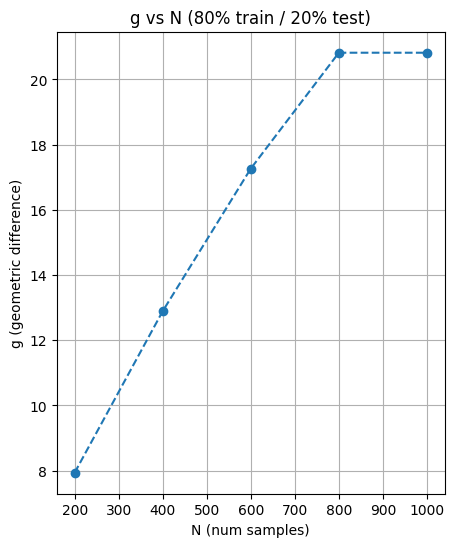

In [18]:
N_list = [200, 400, 600, 800, 1000]
g_list = []
ratio_list = []

X_pca_all = np.vstack([x_train, x_test])   
y_all     = np.hstack([y_train, y_test])

for N in N_list:
    print(f"\n===== N = {N} (train 80% / test 20%) =====")
    N_train = int(0.8 * N)
    N_test  = N - N_train

    X_sub = X_pca_all[:N]
    y_sub = y_all[:N]

    X_train_sub = X_sub[:N_train]
    X_test_sub  = X_sub[N_train:]
    y_train_sub = y_sub[:N_train]
    y_test_sub  = y_sub[N_train:]

    K_q = pqk_kernel.kernel_matrix(X_sub, X_sub)
    K_c = classical_kernel(X_sub, X_sub, gamma=1.0)

    S_pqk, V_pqk = get_spectrum(K_q)
    S_classical, V_classical = get_spectrum(K_c)

    g = geometric_difference(S_pqk, V_pqk, S_classical, V_classical, lambda_v=1.1)
    g_list.append(g)
    ratio_list.append(g / np.sqrt(N))

    print(f"g(N={N})        = {g:.4f}")
    print(f"sqrt(N)         = {np.sqrt(N):.4f}")

plt.figure(figsize=(5, 6))
plt.plot(N_list, g_list, marker='o', linestyle='--')
plt.xlabel("N (num samples)")
plt.ylabel("g (geometric difference)")
plt.title("g vs N (80% train / 20% test)")
plt.grid(True)
plt.show()


# Prediction Accuracy with n qubits

In [19]:
X, y = fetch_openml("Fashion-MNIST", version=1, as_frame=False, return_X_y=True)
y = np.asarray(y).astype(int)

x_train_full, x_test_full = X[:60000], X[60000:]
x_train_full = x_train_full.reshape(-1, 28, 28) / 255.0
x_test_full  = x_test_full.reshape(-1, 28, 28) / 255.0
y_train_full, y_test_full = y[:60000], y[60000:]

X_all = np.vstack([x_train_full.reshape(60000, -1),
                   x_test_full.reshape(10000, -1)])

idx = np.random.permutation(X_all.shape[0])
X_all = X_all[idx]

nqubits_list = list(range(1, 14)) 
N_sample = [100, 600]

results = {N: {"pqk": [], "cls": []} for N in N_sample}

for N in N_sample:
    N_train = int(0.8 * N)
    N_test  = N - N_train

    X_sub = X_all[:N]     
    for n_qubit in nqubits_list:
        print(f"\n===== running for N = {N},  n_qubits = {n_qubit} =====")

        pca = PCA(n_components=n_qubit, random_state=42)
        X_sub_pca = pca.fit_transform(X_sub)          
        xtr_pca = X_sub_pca[:N_train]
        xte_pca = X_sub_pca[N_train:]

        n_layers = 2
        n_params = n_qubit + n_layers * (n_qubit - 1)
        params = np.random.uniform(-2, 2, size=n_params)

        pqk_circuit = pqk_circuit_fn(n_qubit, n_layers)
        pqk_kernel = ProjectedQuantumKernel(
            circuit_fn=pqk_circuit,
            n_qubits=n_qubit,
            n_layers=n_layers,
            params=params,
            gamma=1.0,
            random_state=42
        )

        xtr_q = pqk_kernel.compute_quantum_features(xtr_pca)
        xte_q = pqk_kernel.compute_quantum_features(xte_pca)

        Xq_all = np.vstack([xtr_q, xte_q])  
        K_q_all = pqk_kernel.kernel_matrix(Xq_all, Xq_all)

        S_pqk, V_pqk = get_spectrum(K_q_all)

        K_c_all = classical_kernel(X_sub_pca, X_sub_pca, gamma=1.0)
        S_classical, V_classical = get_spectrum(K_c_all)

        y_relabel = new_label_wnoise(S_pqk, V_pqk, S_classical, V_classical, lambda_v=1.1)
        y_train_new = y_relabel[:N_train]
        y_test_new  = y_relabel[N_train:]

        K_pqk_train = K_q_all[:N_train, :N_train]
        K_pqk_test  = K_q_all[N_train:, :N_train]

        pqk_svc = SVC(kernel="precomputed", C=10, random_state=42)
        pqk_svc.fit(K_pqk_train, y_train_new)
        y_pred_q = pqk_svc.predict(K_pqk_test)
        acc_q = accuracy_score(y_test_new, y_pred_q)

        cls_svc = SVC(kernel="rbf", gamma=1.0, C=10, random_state=42)
        cls_svc.fit(xtr_pca, y_train_new)
        y_pred_c = cls_svc.predict(xte_pca)
        acc_c = accuracy_score(y_test_new, y_pred_c)

        results[N]["pqk"].append(acc_q)
        results[N]["cls"].append(acc_c)


===== running for N = 100,  n_qubits = 1 =====

===== running for N = 100,  n_qubits = 2 =====

===== running for N = 100,  n_qubits = 3 =====

===== running for N = 100,  n_qubits = 4 =====

===== running for N = 100,  n_qubits = 5 =====

===== running for N = 100,  n_qubits = 6 =====

===== running for N = 100,  n_qubits = 7 =====

===== running for N = 100,  n_qubits = 8 =====

===== running for N = 100,  n_qubits = 9 =====

===== running for N = 100,  n_qubits = 10 =====

===== running for N = 100,  n_qubits = 11 =====

===== running for N = 100,  n_qubits = 12 =====

===== running for N = 100,  n_qubits = 13 =====

===== running for N = 600,  n_qubits = 1 =====

===== running for N = 600,  n_qubits = 2 =====

===== running for N = 600,  n_qubits = 3 =====

===== running for N = 600,  n_qubits = 4 =====

===== running for N = 600,  n_qubits = 5 =====

===== running for N = 600,  n_qubits = 6 =====

===== running for N = 600,  n_qubits = 7 =====

===== running for N = 600,  n_qubit

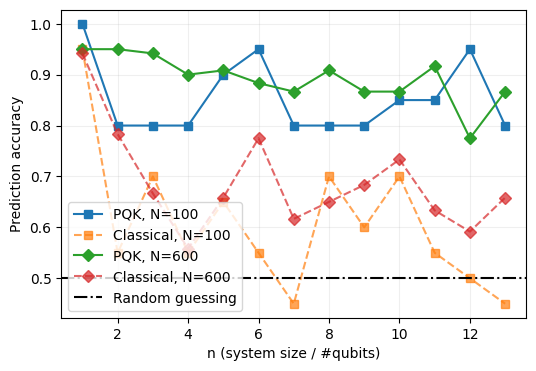

In [21]:
fig, ax = plt.subplots(figsize=(6, 4))

for N, color, marker in [(100, "tab:blue", "s"), (600, "tab:orange", "D")]:
    ax.plot(nqubits_list, results[N]["pqk"], marker=marker, linestyle="-", label=f"PQK, N={N}")
    ax.plot(nqubits_list, results[N]["cls"], marker=marker, linestyle="--", alpha=0.7, label=f"Classical, N={N}")

ax.axhline(0.5, color="k", linestyle="-.", label="Random guessing")

ax.set_xlabel("n (system size / #qubits)")
ax.set_ylabel("Prediction accuracy")
ax.legend()
ax.grid(alpha=0.2)

plt.show()

In [22]:
print(results[100]["pqk"])
print(results[600]["pqk"])
print(results[100]["cls"])
print(results[600]["cls"])

[1.0, 0.8, 0.8, 0.8, 0.9, 0.95, 0.8, 0.8, 0.8, 0.85, 0.85, 0.95, 0.8]
[0.95, 0.95, 0.9416666666666667, 0.9, 0.9083333333333333, 0.8833333333333333, 0.8666666666666667, 0.9083333333333333, 0.8666666666666667, 0.8666666666666667, 0.9166666666666666, 0.775, 0.8666666666666667]
[0.95, 0.55, 0.7, 0.55, 0.65, 0.55, 0.45, 0.7, 0.6, 0.7, 0.55, 0.5, 0.45]
[0.9416666666666667, 0.7833333333333333, 0.6666666666666666, 0.5583333333333333, 0.6583333333333333, 0.775, 0.6166666666666667, 0.65, 0.6833333333333333, 0.7333333333333333, 0.6333333333333333, 0.5916666666666667, 0.6583333333333333]
